# Predicting Forest Cover Types
## Mod 5 - Kaggle Competition - Machine Learning

![alt text](forest.png "title")

<span style="color:green">by *Valentina Fontiveros*</span>

# Read Dataset

At this stage, we have generated several features and done visualization steps.

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Paired'

import seaborn as sns
sns.palplot(sns.color_palette("Paired"))
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#!pip install lightgbm
from lightgbm import LGBMClassifier
#!pip install mlxtend  
from mlxtend.classifier import StackingCVClassifier

from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler


random_state = 1
random.seed(random_state)
np.random.seed(random_state)


import os
import random
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

from imblearn.over_sampling import RandomOverSampler

from lightgbm import LGBMClassifier

#!pip install mlxtend  
from mlxtend.classifier import StackingCVClassifier

from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

random_state = 1
random.seed(random_state)
np.random.seed(random_state)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# Read labeled data "train"
labeled_data = pd.read_csv('train_Oct11_Step1.csv', dtype = 'float')
labeled_data.index = labeled_data.index + 1
labeled_data.drop('Id',axis=1,inplace=True)
labels = labeled_data.Cover_Type
labeled_data.tail()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Temp_9am,Temp_Noon,Temp_3pm,Elev_Vhydro_diff,Hhydro_Fire_sum,Hhydro_Fire_diff,Hhydro_Road_sum,Hhydro_Road_diff,Road_Fire_sum,Road_Fire_diff
15116,2607.0,243.0,23.0,258.0,7.0,660.0,170.0,251.0,214.0,1282.0,...,95.707276,588.594253,404.675396,2600.0,1540.0,1024.0,918.0,402.0,1942.0,622.0
15117,2603.0,121.0,19.0,633.0,195.0,618.0,249.0,221.0,91.0,1325.0,...,590.679139,145.389441,12.997776,2408.0,1958.0,692.0,1251.0,15.0,1943.0,707.0
15118,2492.0,134.0,25.0,365.0,117.0,335.0,250.0,220.0,83.0,1187.0,...,603.499543,214.570085,23.294797,2375.0,1552.0,822.0,700.0,30.0,1522.0,852.0
15119,2487.0,167.0,28.0,218.0,101.0,242.0,229.0,237.0,119.0,932.0,...,503.644536,414.612305,92.230825,2386.0,1150.0,714.0,460.0,24.0,1174.0,690.0
15120,2475.0,197.0,34.0,319.0,78.0,270.0,189.0,244.0,164.0,914.0,...,314.483347,548.677056,211.948960,2397.0,1233.0,595.0,589.0,49.0,1184.0,644.0


In [3]:
# Read unlabeled data "test"
unlabeled_data = pd.read_csv('test_Oct11_Step1.csv', dtype = 'float')
unlabeled_data.index = unlabeled_data.index + 15121
unlabeled_data.drop('Id',axis=1,inplace=True)
unlabeled_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Temp_9am,Temp_Noon,Temp_3pm,Elev_Vhydro_diff,Hhydro_Fire_sum,Hhydro_Fire_diff,Hhydro_Road_sum,Hhydro_Road_diff,Road_Fire_sum,Road_Fire_diff
15121,2680.0,354.0,14.0,0.0,0.0,2684.0,196.0,214.0,156.0,6645.0,...,-1.941387e+01,23.541406,172.306440,2680.0,6645.0,6645.0,2684.0,2684.0,NaN,3961.0
15122,2683.0,0.0,13.0,0.0,0.0,2654.0,201.0,216.0,152.0,6675.0,...,1.230770e-14,0.000000,152.000000,2683.0,6675.0,6675.0,2654.0,2654.0,NaN,4021.0
15123,2713.0,16.0,15.0,0.0,0.0,2980.0,206.0,208.0,137.0,6344.0,...,6.476139e+01,-49.275003,99.237682,2713.0,6344.0,6344.0,2980.0,2980.0,NaN,3364.0
15124,2709.0,24.0,17.0,0.0,0.0,2950.0,208.0,201.0,125.0,6374.0,...,1.025838e+02,-64.376702,74.157920,2709.0,6374.0,6374.0,2950.0,2950.0,NaN,3424.0
15125,2706.0,29.0,19.0,0.0,0.0,2920.0,210.0,195.0,115.0,6404.0,...,1.281399e+02,-70.088719,59.246894,2706.0,6404.0,6404.0,2920.0,2920.0,NaN,3484.0


### Preprocessing - Feature Selection

In [ ]:
labeled_drop_soil = labeled_data.drop(labeled_data.columns[14:54],axis=1)
unlabeled_drop_soil = unlabeled_data.drop(unlabeled_data.columns[14:54],axis=1)

In [4]:
# Drop features
labeled_data = labeled_data.drop(['Cover_Type', 'Wilderness_Area'],axis=1)
unlabeled_data = unlabeled_data.drop(['Wilderness_Area'],axis=1)

In [5]:
labeled_data['Road_Fire_sum'] = labeled_data.Horizontal_Distance_To_Roadways + labeled_data.Horizontal_Distance_To_Fire_Points
unlabeled_data['Road_Fire_sum'] = unlabeled_data.Horizontal_Distance_To_Roadways + unlabeled_data.Horizontal_Distance_To_Fire_Points


In [ ]:
# Drop correlated features
#corr_features = ['Light_Exposure','South_Normed','Soil_Lithics','Outcrop_1.0','Outcrop_2.0','Wilderness_Area4','Aspect','Soil_Drainage','Slope','Absolute_Distance_to_Hydrology','South', 'West', 'North','Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology','Soil_Depth','Hillshade_9am', 'Hillshade_Noon','East','East_Normed', 'Hillshade_3pm','Wilderness_Area1','Outcrop_0.0']
#labeled_features = labeled_features.drop(corr_features,axis=1)
#unlabeled_features = unlabeled_features.drop(corr_features,axis=1)

In [6]:
len(labeled_data.columns)

82

In [7]:
len(labeled_data.columns) == len(unlabeled_data.columns)

True

In [8]:
labeled_data.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [9]:
# all data for labeled and unlabeled data 
X = pd.concat([labeled_data,unlabeled_data])

In [10]:
X.index

RangeIndex(start=1, stop=581013, step=1)

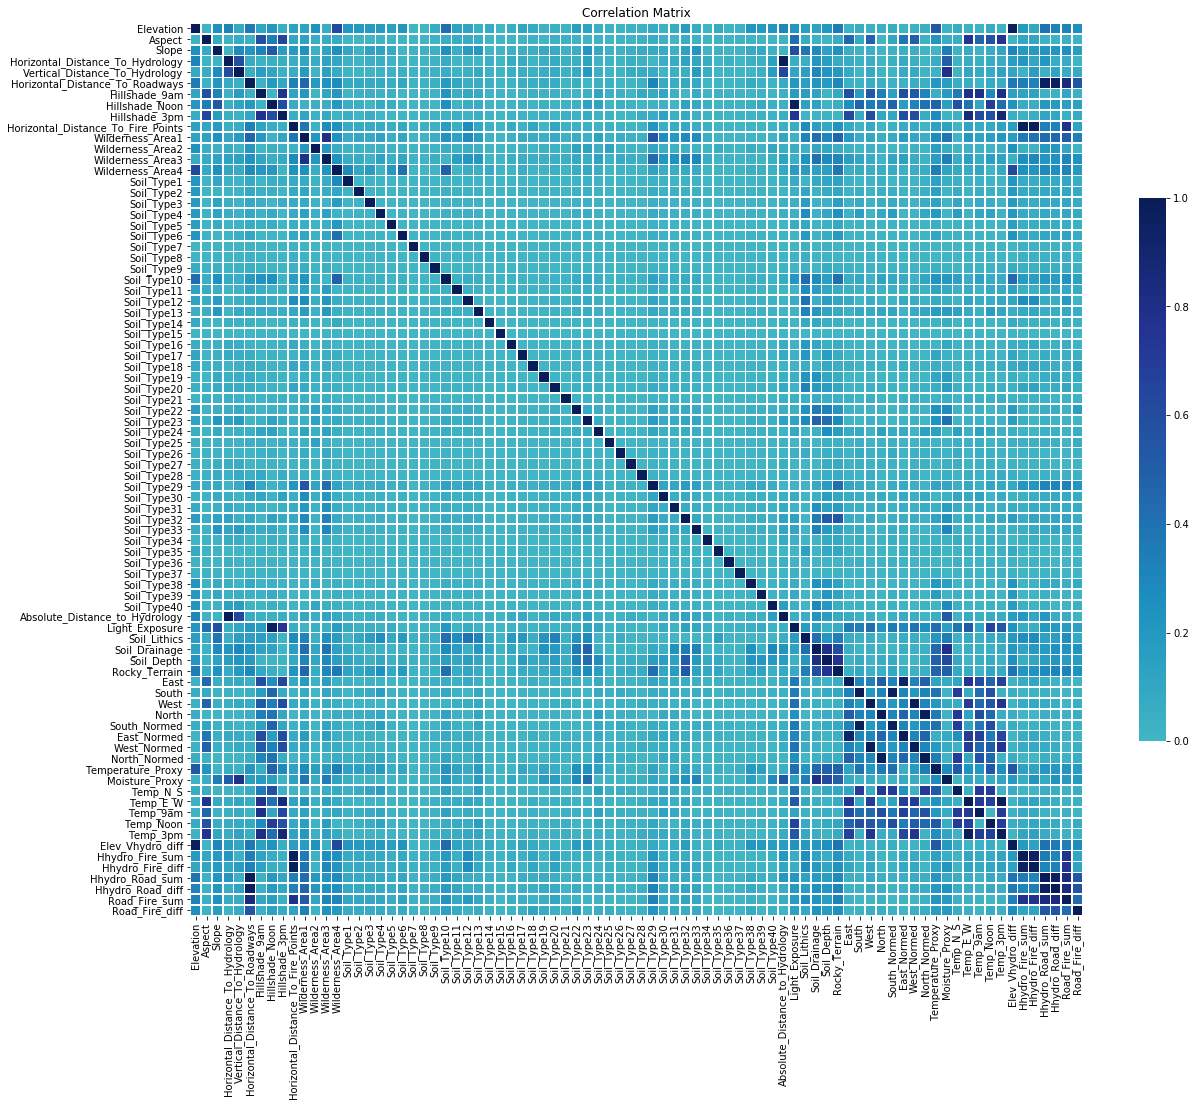

In [11]:
plt.subplots(figsize=(20, 20))
sns.heatmap(np.abs(X.corr()),center=0,square=True, linewidths=.5, cmap="YlGnBu",cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

In [12]:
len(labeled_data.columns)

82

In [ ]:
# Remove irrelevant features
drop_feat = ['Slope','Soil_Type7','Soil_Type15','Aspect','Hillshade_9am','Hillshade_3pm','Hillshade_Noon','East','South','North','West','East_Normed',
            'West_Normed','North_Normed','South_Normed','Temp_9am','Temp_Noon','Temp_3pm','Soil_Depth','Soil_Drainage',
            'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology']

In [ ]:
X.drop(drop_feat,axis=1,inplace=True)
unlabeled_data.drop(drop_feat,axis=1,inplace=True)
labeled_data.drop(drop_feat,axis=1,inplace=True)
plt.subplots(figsize=(20, 20))
sns.heatmap(np.abs(X.corr()),center=0,square=True, linewidths=.5, cmap="YlGnBu",cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

In [ ]:
soil_num = [1,2,5,6,8,9,11,13,14,16,17,18,19,20,21,24,25,26,27,28,31,34,35,36]

drop_soils = []

for num in soil_num:
    string = 'Soil_Type{}'.format(num)
    drop_soils.append(string)

X.drop(drop_soils,axis=1,inplace=True)
unlabeled_data.drop(drop_soils,axis=1,inplace=True)
labeled_data.drop(drop_soils,axis=1,inplace=True)
plt.subplots(figsize=(20, 20))
sns.heatmap(np.abs(X.corr()),center=0,square=True, linewidths=.5, cmap="YlGnBu",cbar_kws={"shrink": .5})

## Preprocessing - Train Test Split

In [13]:
def get_wa_data(X, wa):
    # Get data for a Wilderness_Area
    X_wa = X[X['Wilderness_Area{}'.format(wa)] == 1]
    
    return X_wa


In [14]:
def performance(y_true, y_predict):
    from sklearn.metrics import accuracy_score 
    from sklearn.metrics import mean_squared_error  
    from sklearn.metrics import r2_score 
    acc = accuracy_score(y_true, y_predict)
    r2 = r2_score(y_true,y_predict)
    mse = mean_squared_error(y_true,y_predict)
    # Return the score
    return ['Accuracy: ',acc,'R-squared: ', r2,'Mean Squared Error: ',mse]



             

In [15]:
# drop empty or label features to be dropped from the modeling. \
# outputs X_train, 
def preprocess(labeled_wa,labels_wa,unlabeled_wa,test_size):
    
    ''' This function takes in all feature data (even unlabeled features) and scales it.
        Splits data in train set and test sets, as well as outputs unlabeled features as a separate
        dataframe for later prediction. '''
    
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    
    print('Preprocessing Step')

    X = pd.concat([labeled_wa, unlabeled_wa])
    print('X Records: ',len(X))
    
    # Drop features with low variance in training set
    lo_var_cols = []
    max_mode_freq = len(labeled_wa) - 10
    
    for col in labeled_wa.columns:
        if  X.loc[labeled_wa.index, col].value_counts().iat[0] > max_mode_freq:
            lo_var_cols.append(col)
    
    if lo_var_cols:
        labeled_wa = labeled_wa.drop(lo_var_cols, axis='columns')
        unlabeled_wa  = unlabeled_wa.drop(lo_var_cols, axis='columns')
        X = X.drop(lo_var_cols, axis='columns')
   
    print('X Records: ',len(X))   
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X))
    X_scaled.columns = X.columns
    X_scaled.index = X.index
   
    print('X scaled Records: ',len(X_scaled))  
    
    labeled_wa_scaled =  X_scaled.loc[labeled_wa.index,:]
 
    unlabeled_wa_scaled = X_scaled.loc[unlabeled_wa.index,:]
    
    X_train, X_test, y_train, y_test = train_test_split(labeled_wa_scaled,labels_wa,test_size=test_size,random_state=14)

    return X_train, X_test, y_train, y_test, unlabeled_wa_scaled

In [16]:
def upsample(X_, y_):
    # Upsample for equal class counts
    # https://www.kaggle.com/shahules/tackling-class-imbalance
    
    X = X_.copy()
    y = y_.copy()
    
    max_samples = y.value_counts().iat[0]
    classes = y.unique().tolist()
    sampling_strategy = dict((cl, max_samples) for cl in classes)

    sampler = RandomOverSampler(sampling_strategy=sampling_strategy,
                                random_state=random_state)

    x_columns = X.columns.tolist()
    X, y = sampler.fit_resample(X, y)
    X = pd.DataFrame(X, columns=x_columns)
    y = pd.Series(y)
    
    return X, y


### Train by Wildlife Area

In [17]:
# model 1

ab_clf = AdaBoostClassifier(n_estimators=200,
                            base_estimator=DecisionTreeClassifier(
                                min_samples_leaf=2,
                                random_state=random_state),
                            random_state=random_state)

et_clf = ExtraTreesClassifier(n_estimators=300,
                              min_samples_leaf=2,
                              min_samples_split=2,
                              max_depth=50,
                              random_state=random_state,
                              n_jobs=1)

lg_clf = LGBMClassifier(n_estimators=300,
                        num_leaves=128,
                        verbosity=-1,
                        random_state=random_state,
                        n_jobs=1)

rf_clf = RandomForestClassifier(n_estimators=400,
                                random_state=random_state,
                                n_jobs=1)


ensemble = [('AdaBoostClassifier', ab_clf),
            ('ExtraTreesClassifier', et_clf),
            ('LGBMClassifier', lg_clf),
            ('RandomForestClassifier', rf_clf)]


In [40]:
def randomforest_train(X_train, X_test,y_train,y_test):
    
    from sklearn.metrics import accuracy_score
    from sklearn.ensemble import RandomForestClassifier
    
    print('Applying Random Forest Classifier...')
    
    clf = RandomForestClassifier(criterion='entropy',n_estimators=400)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    print(performance(y_train,y_train_pred))
    
    training_accuracy = accuracy_score(y_train,y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    
    feature_importances = clf.feature_importances_
    print('')
    print('Training Accuracy: ', training_accuracy)
    print('Testin Accuracy: ', testing_accuracy)
    print('')
    
    print(feature_importances)
    df = pd.DataFrame([X_train.columns,feature_importances])
    df = df.T
    df.columns = ['Features','Importances']
    df = df.sort_values(by='Importances',ascending=False)
    df = df[df.Importances > 0.009]
    features = list(df.Features)
    
    print(df)
    return features

In [41]:
def heatmap_wa(X_train, features):
    import seaborn as sns
    plt.subplots(figsize=(20, 20))
    sns.heatmap(np.abs((X_train[features]).corr()),center=0,square=True, linewidths=.5, cmap="YlGnBu",cbar_kws={"shrink": .5})
    plt.title('Correlation Matrix')
    plt.show()

## RUN Stacked Model

> Processing Wilderness Areas separately
> ========== 1 ==========
> Extracting data for Wilderness_Area1
Labeled records:  3597
Label records:  3597
Unlabeled Records:  257199
> Processing features in Wilderness_Area1
Preprocessing Step
X Records:  260796
X Records:  260796
X scaled Records:  260796
  -- Xtrain features = 54
  -- Xtest features = 54
  -- ytrainof records = 2697
  -- ytest of records = 900
  -- unlabeled of features = 54
  -- unlabeled records = 257199
> Fitting a preliminary Random Forest model to check feature importances...
Applying Random Forest Classifier...
['Accuracy: ', 1.0, 'R-squared: ', 1.0, 'Mean Squared Error: ', 0.0]

Training Accuracy:  1.0
Testin Accuracy:  0.8722222222222222

[1.49776385e-01 1.18860763e-02 1.41100065e-02 1.76235577e-02
 1.61692529e-02 6.15712278e-02 1.42104648e-02 1.40216340e-02
 2.00176228e-02 3.15710184e-02 4.26055378e-05 6.27740895e-03
 4.77790849e-04 5.74992281e-04 1.91602703e-04 1.01379318e-03
 3.78885640e-03 2.61699905e-03 3.5541

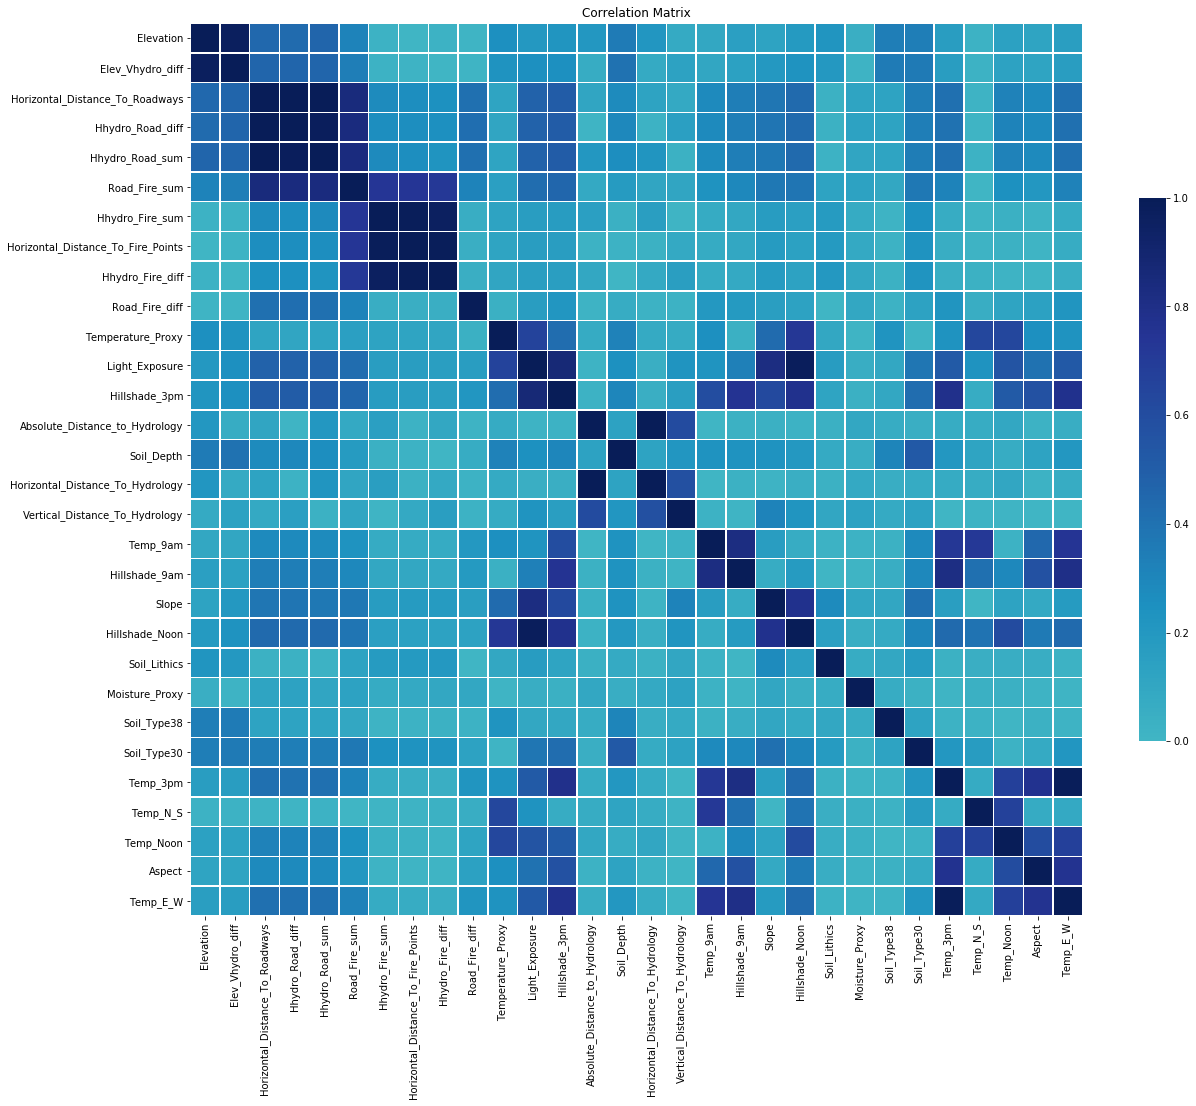


> Adjusting models for Wilderness_Area1
30
Cross-validating classifiers in Wilderness_Area1
Train:  [0.81330869 0.86321627 0.84814815 0.86431227 0.84916201]
Test:  [0.79120879 0.72375691 0.78888889 0.82681564 0.76966292]
Train:  [0.84658041 0.87985213 0.85       0.88289963 0.88081937]
Test:  [0.8021978  0.75138122 0.82222222 0.83798883 0.79213483]
Train:  [0.83548983 0.86321627 0.87222222 0.87732342 0.86778399]
Test:  [0.81868132 0.74585635 0.81111111 0.77094972 0.78651685]
Train:  [0.82994455 0.87985213 0.85185185 0.8605948  0.8603352 ]
Test:  [0.77472527 0.75690608 0.82222222 0.82681564 0.79213483]
> Up-sampling in Wilderness_Area1
> Fitting stack for Wilderness_Area1
Fitting 4 classifiers...
Fitting classifier1: adaboostclassifier (1/4)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: extratreesclassifier (2/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: lgbmclassifier (3/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: randomforestclassifier (4/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.5s finished


Train Set:  ['Accuracy: ', 1.0, 'R-squared: ', 1.0, 'Mean Squared Error: ', 0.0]
Test Set:   ['Accuracy: ', 0.9003496503496503, 'R-squared: ', 0.8896488127257358, 'Mean Squared Error: ', 0.6276223776223776]
> Making predictions for Wilderness_Area1
> Creating submission for Wilderness_Area1
> Done !
> Processing Wilderness Areas separately
> ========== 2 ==========
> Extracting data for Wilderness_Area2
Labeled records:  499
Label records:  499
Unlabeled Records:  29385
> Processing features in Wilderness_Area2
Preprocessing Step
X Records:  29884
X Records:  29884
X scaled Records:  29884
  -- Xtrain features = 46
  -- Xtest features = 46
  -- ytrainof records = 374
  -- ytest of records = 125
  -- unlabeled of features = 46
  -- unlabeled records = 29385
> Fitting a preliminary Random Forest model to check feature importances...
Applying Random Forest Classifier...
['Accuracy: ', 1.0, 'R-squared: ', 1.0, 'Mean Squared Error: ', 0.0]

Training Accuracy:  1.0
Testin Accuracy:  0.888

[

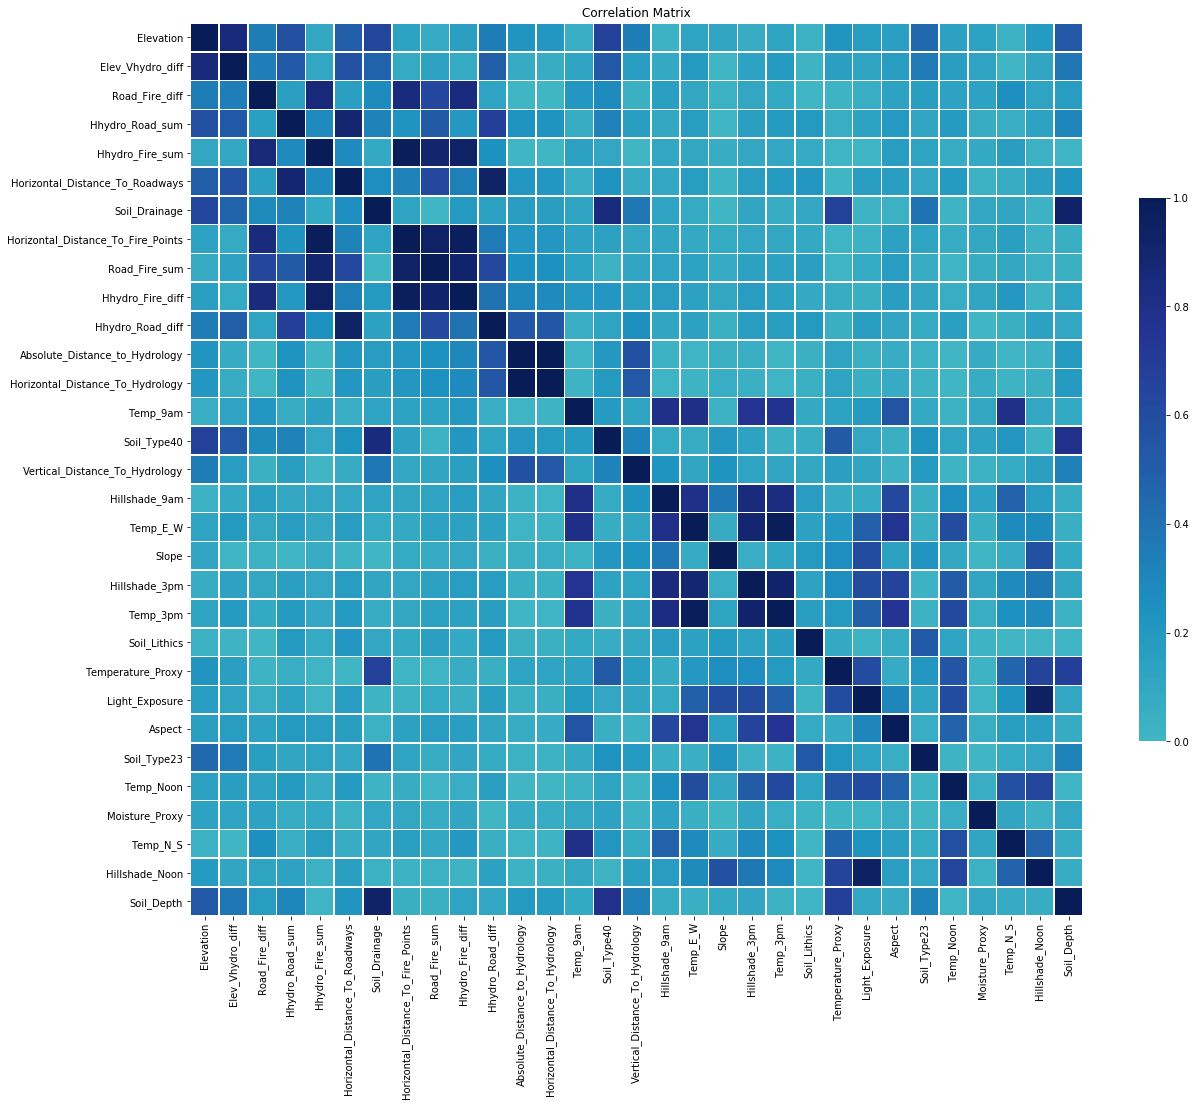


> Adjusting models for Wilderness_Area2
31
Cross-validating classifiers in Wilderness_Area2
Train:  [0.86842105 0.89473684 0.86666667 0.86486486 0.84931507]
Test:  [0.69230769 0.76923077 0.69230769 0.91666667 0.86956522]
Train:  [0.85526316 0.88157895 0.84       0.86486486 0.84931507]
Test:  [0.69230769 0.69230769 0.69230769 0.91666667 0.7826087 ]
Train:  [0.92105263 0.88157895 0.88       0.83783784 0.84931507]
Test:  [0.73076923 0.73076923 0.73076923 0.75       0.86956522]
Train:  [0.90789474 0.86842105 0.86666667 0.86486486 0.8630137 ]
Test:  [0.69230769 0.76923077 0.76923077 0.91666667 0.82608696]
> Up-sampling in Wilderness_Area2
> Fitting stack for Wilderness_Area2
Fitting 4 classifiers...
Fitting classifier1: adaboostclassifier (1/4)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: extratreesclassifier (2/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: lgbmclassifier (3/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: randomforestclassifier (4/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Train Set:  ['Accuracy: ', 1.0, 'R-squared: ', 1.0, 'Mean Squared Error: ', 0.0]
Test Set:   ['Accuracy: ', 0.7619047619047619, 'R-squared: ', 0.9385560675883257, 'Mean Squared Error: ', 0.42328042328042326]
> Making predictions for Wilderness_Area2
> Creating submission for Wilderness_Area2
> Done !
> Processing Wilderness Areas separately
> ========== 3 ==========
> Extracting data for Wilderness_Area3
Labeled records:  6349
Label records:  6349
Unlabeled Records:  247015
> Processing features in Wilderness_Area3
Preprocessing Step
X Records:  253364
X Records:  253364
X scaled Records:  253364
  -- Xtrain features = 64
  -- Xtest features = 64
  -- ytrainof records = 4761
  -- ytest of records = 1588
  -- unlabeled of features = 64
  -- unlabeled records = 247015
> Fitting a preliminary Random Forest model to check feature importances...
Applying Random Forest Classifier...
['Accuracy: ', 1.0, 'R-squared: ', 1.0, 'Mean Squared Error: ', 0.0]

Training Accuracy:  1.0
Testin Accuracy:

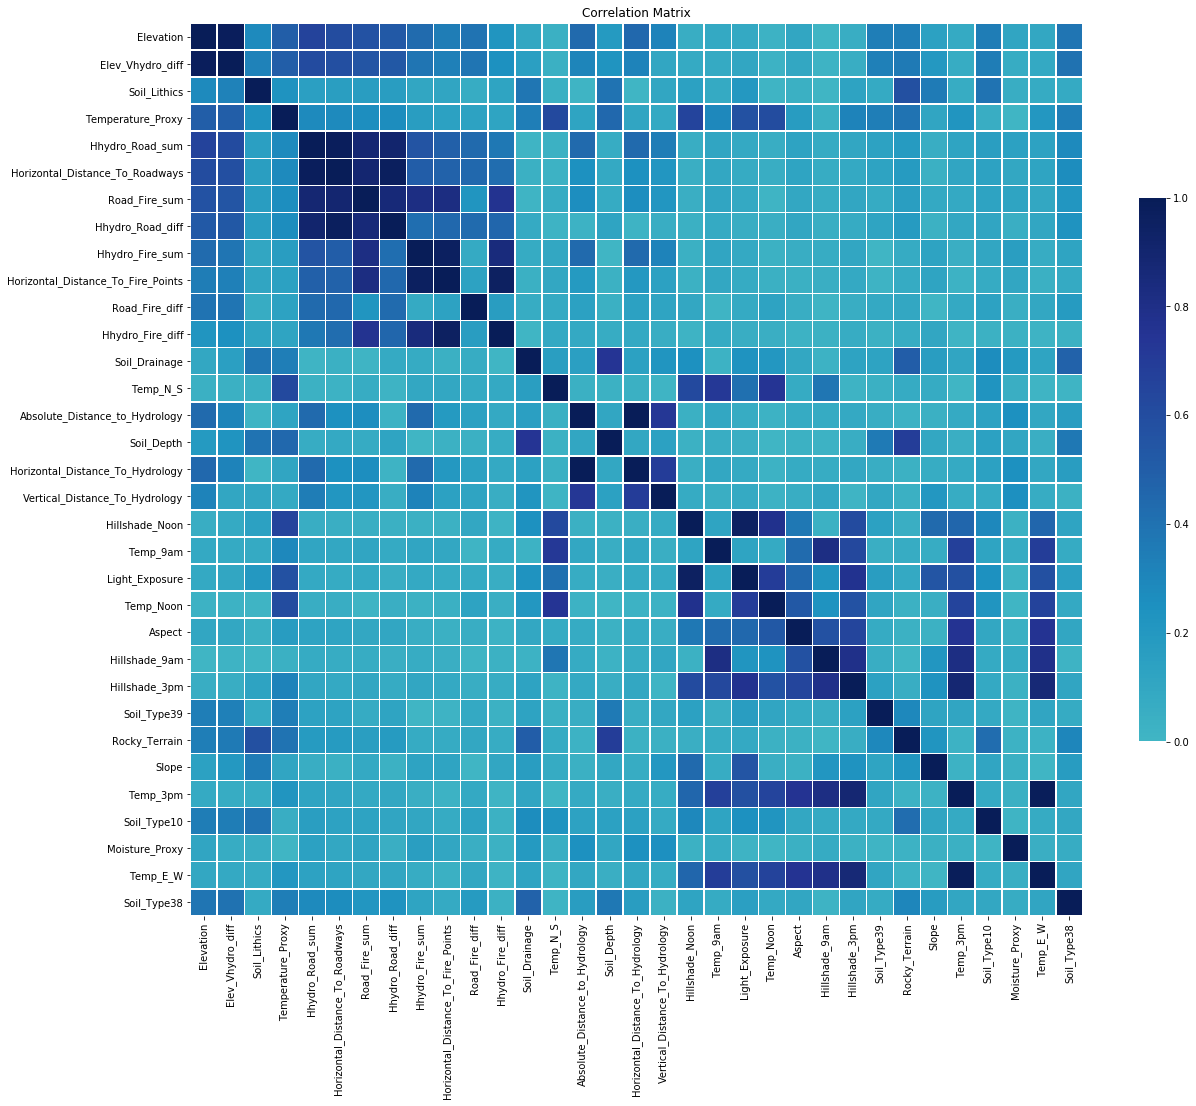


> Adjusting models for Wilderness_Area3
33
Cross-validating classifiers in Wilderness_Area3
Train:  [0.85639413 0.86463799 0.84365163 0.84768908 0.85774499]
Test:  [0.84326019 0.78683386 0.81504702 0.82018927 0.77070064]
Train:  [0.86163522 0.86463799 0.85204617 0.86029412 0.85985248]
Test:  [0.84326019 0.79623824 0.830721   0.80126183 0.79299363]
Train:  [0.85534591 0.86988458 0.86044071 0.86554622 0.8682824 ]
Test:  [0.82758621 0.76489028 0.80564263 0.81388013 0.78025478]
Train:  [0.85220126 0.86883526 0.84260231 0.84558824 0.86195996]
Test:  [0.84012539 0.78369906 0.81504702 0.82018927 0.77388535]
> Up-sampling in Wilderness_Area3
> Fitting stack for Wilderness_Area3
Fitting 4 classifiers...
Fitting classifier1: adaboostclassifier (1/4)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: extratreesclassifier (2/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: lgbmclassifier (3/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: randomforestclassifier (4/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.9s finished


Train Set:  ['Accuracy: ', 1.0, 'R-squared: ', 1.0, 'Mean Squared Error: ', 0.0]
Test Set:   ['Accuracy: ', 0.8672480620155039, 'R-squared: ', 0.7226951827242525, 'Mean Squared Error: ', 1.2940891472868217]
> Making predictions for Wilderness_Area3
> Creating submission for Wilderness_Area3
> Done !
> Processing Wilderness Areas separately
> ========== 4 ==========
> Extracting data for Wilderness_Area4
Labeled records:  4675
Label records:  4675
Unlabeled Records:  32293
> Processing features in Wilderness_Area4
Preprocessing Step
X Records:  36968
X Records:  36968
X scaled Records:  36968
  -- Xtrain features = 49
  -- Xtest features = 49
  -- ytrainof records = 3506
  -- ytest of records = 1169
  -- unlabeled of features = 49
  -- unlabeled records = 32293
> Fitting a preliminary Random Forest model to check feature importances...
Applying Random Forest Classifier...
['Accuracy: ', 1.0, 'R-squared: ', 1.0, 'Mean Squared Error: ', 0.0]

Training Accuracy:  1.0
Testin Accuracy:  0.91

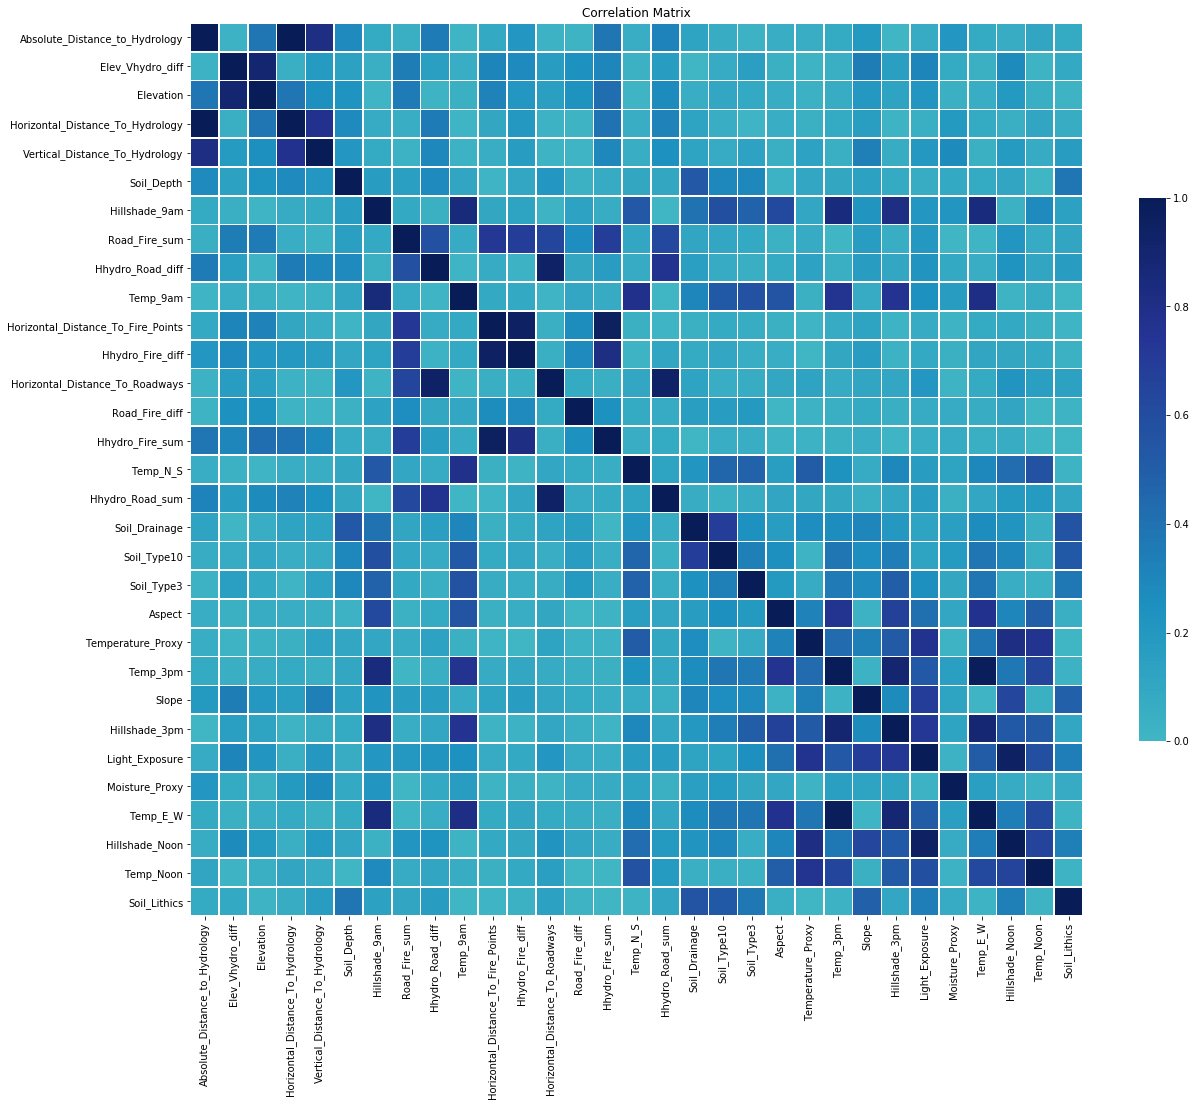


> Adjusting models for Wilderness_Area4
31
Cross-validating classifiers in Wilderness_Area4
Train:  [0.92034139 0.91880342 0.8974359  0.89714286 0.90987124]
Test:  [0.85531915 0.84615385 0.84615385 0.86324786 0.875     ]
Train:  [0.92034139 0.91452991 0.9017094  0.89142857 0.90844063]
Test:  [0.85531915 0.7991453  0.83333333 0.86752137 0.875     ]
Train:  [0.93172119 0.91595442 0.9045584  0.91857143 0.91130186]
Test:  [0.85531915 0.85897436 0.84615385 0.85897436 0.85775862]
Train:  [0.91180654 0.90883191 0.88176638 0.88857143 0.88125894]
Test:  [0.84255319 0.82905983 0.82478632 0.87179487 0.8362069 ]
> Up-sampling in Wilderness_Area4
> Fitting stack for Wilderness_Area4
Fitting 4 classifiers...
Fitting classifier1: adaboostclassifier (1/4)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: extratreesclassifier (2/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: lgbmclassifier (3/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: randomforestclassifier (4/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.6s finished


Train Set:  ['Accuracy: ', 1.0, 'R-squared: ', 1.0, 'Mean Squared Error: ', 0.0]
Test Set:   ['Accuracy: ', 0.7577838827838828, 'R-squared: ', 0.3488226059654631, 'Mean Squared Error: ', 1.4244505494505495]
> Making predictions for Wilderness_Area4
> Creating submission for Wilderness_Area4
> Done !


In [44]:
for wa in range(1, 5):

    print('> Processing Wilderness Areas separately')
    predictions = pd.Series(dtype=labels.dtype)
    cross_val_only = False
    
    print('> ========== {} =========='.format(wa))
    
    print('> Extracting data for Wilderness_Area{}'.format(wa))
    labeled_wa = get_wa_data(labeled_data, wa)
    print('Labeled records: ',len(labeled_wa))
    labels_wa = labels.loc[labeled_wa.index]
    print('Label records: ',len(labels_wa))
    unlabeled_wa = get_wa_data(unlabeled_data, wa) 
    print('Unlabeled Records: ',len(unlabeled_wa))
    
    print('> Processing features in Wilderness_Area{}'.format(wa))

    X_train_wa, X_test_wa, y_train_wa, y_test_wa, unlabeled_scaled_wa = preprocess(labeled_wa,labels_wa,unlabeled_wa, 0.25)

    print('  -- Xtrain features = {}'.format(X_train_wa.columns.size))
    print('  -- Xtest features = {}'.format(X_test_wa.columns.size))
    print('  -- ytrainof records = {}'.format(len(y_train_wa)))
    print('  -- ytest of records = {}'.format(len(y_test_wa)))
    print('  -- unlabeled of features = {}'.format(unlabeled_scaled_wa.columns.size))
    print('  -- unlabeled records = {}'.format(len(unlabeled_scaled_wa)))
    
    print('> Fitting a preliminary Random Forest model to check feature importances...')
    
    features = randomforest_train(X_train_wa, X_test_wa,y_train_wa,y_test_wa)
    print(features)
    heatmap_wa(X_train_wa, features)
    
    print("")
    
    print('> Adjusting models for Wilderness_Area{}'.format(wa))
    
    #max_features = min(30, X_train_wa.columns.size)
    
    X_train_wa = X_train_wa[features]
    X_test_wa = X_test_wa[features]
    
    max_features = X_train_wa.columns.size
    et_clf.set_params(max_features=max_features)
    
    print(max_features)
    
    
    
    print('Cross-validating classifiers in Wilderness_Area{}'.format(wa))

    for label, clf in ensemble:
        score = cross_val_score(clf, X_train_wa, y_train_wa,
                                cv=5,
                                scoring='accuracy',
                                verbose=0,
                                n_jobs=-1)
        score2 = cross_val_score(clf, X_test_wa, y_test_wa,
                                cv=5,
                                scoring='accuracy',
                                verbose=0,
                                n_jobs=-1)
        print('Train: ',score)
        print('Test: ',score2)
    
    print('> Up-sampling in Wilderness_Area{}'.format(wa))
    
    X_train_wa, y_train_wa = upsample(X_train_wa, y_train_wa)
    X_test_wa, y_test_wa = upsample(X_test_wa, y_test_wa)
    
    print('> Fitting stack for Wilderness_Area{}'.format(wa))
    # https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
    # https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
    
    stack = StackingCVClassifier(classifiers=[ab_clf, et_clf, lg_clf, rf_clf],
                                 meta_classifier=rf_clf,
                                 cv=5,
                                 stratify=True,
                                 shuffle=True,
                                 use_probas=True,
                                 use_features_in_secondary=True,
                                 verbose=1,
                                 random_state=random_state)
    
    stack = stack.fit(X_train_wa, y_train_wa)
    y_train_pred_wa = stack.predict(X_train_wa)
    print('Train Set: ', performance(y_train_wa,y_train_pred_wa))
    
    y_test_pred_wa = stack.predict(X_test_wa)
    print('Test Set:  ', performance(y_test_wa, y_test_pred_wa))
    
    
    print('> Making predictions for Wilderness_Area{}'.format(wa))
    prediction_wa = stack.predict(unlabeled_scaled_wa[features])
    
    prediction_wa = pd.DataFrame(prediction_wa, index=unlabeled_scaled_wa.index)

    
    print('> Creating submission for Wilderness_Area{}'.format(wa))

    predictions = prediction_wa.sort_index()
    predictions.to_csv('submission_wa_model3{}.csv'.format(wa), header=['Cover_Type'], index=True, index_label='Id')

    print('> Done !')
    



## Read Data

In [45]:
wa1 = pd.read_csv('submission_wa_model31.csv')
wa2 = pd.read_csv('submission_wa_model32.csv')
wa3 = pd.read_csv('submission_wa_model33.csv')
wa4 = pd.read_csv('submission_wa_model34.csv')

was = [wa1,wa2,wa3,wa4]

final_pred = pd.concat([wa1,wa2,wa3,wa4])
final_pred = final_pred.sort_values(by='Id')
final_pred = final_pred.astype('int')


# write final predictions to disk
final_pred.to_csv('final_submission_Oct17_model4_feature_importances.csv', header=['Id','Cover_Type'], index=False)
print('Wrote submission to disk.')

Wrote submission to disk.


In [ ]:
final_pred.head()

In [ ]:
# Read labeled data "train"
labeled_data = pd.read_csv('train_Oct11_Step1.csv', dtype = 'float')
labeled_data.index = labeled_data.index + 1
labeled_data.drop('Id',axis=1,inplace=True)
labels = labeled_data.Cover_Type
labeled_data.tail()

In [ ]:
# Read unlabeled data "test"
unlabeled_data = pd.read_csv('test_Oct11_Step1.csv', dtype = 'float')
unlabeled_data.index = unlabeled_data.index + 15121
unlabeled_data.drop('Id',axis=1,inplace=True)
unlabeled_data.head()

In [ ]:
plt.scatter(labeled_data.Cover_Type, labeled_data.Elevation, c=labeled_data.Cover_Type)

In [ ]:
plt.scatter(final_pred.Cover_Type, unlabeled_data.Elevation, c=final_pred.Cover_Type)

In [ ]:
width = 0.20
labels = ['Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']

x = np.arange(len(labels))

N = 4

ind = np.arange(N)


ct1 = (len(wa1[wa1.Cover_Type==1]), len(wa2[wa2.Cover_Type==1]), len(wa3[wa3.Cover_Type==1]), len(wa4[wa4.Cover_Type==1]))
ct2 = (len(wa1[wa1.Cover_Type==2]), len(wa2[wa2.Cover_Type==2]), len(wa3[wa3.Cover_Type==2]), len(wa4[wa4.Cover_Type==2]))
ct3 = (len(wa1[wa1.Cover_Type==3]), len(wa2[wa2.Cover_Type==3]), len(wa3[wa3.Cover_Type==3]), len(wa4[wa4.Cover_Type==3]))
ct4 = (len(wa1[wa1.Cover_Type==4]), len(wa2[wa2.Cover_Type==4]), len(wa3[wa3.Cover_Type==4]), len(wa4[wa4.Cover_Type==4]))                                                                       
ct5 = (len(wa1[wa1.Cover_Type==5]), len(wa2[wa2.Cover_Type==5]), len(wa3[wa3.Cover_Type==5]), len(wa4[wa4.Cover_Type==5]))
ct6 = (len(wa1[wa1.Cover_Type==6]), len(wa2[wa2.Cover_Type==6]), len(wa3[wa3.Cover_Type==6]), len(wa4[wa4.Cover_Type==6]))
ct7 = (len(wa1[wa1.Cover_Type==7]), len(wa2[wa2.Cover_Type==7]), len(wa3[wa3.Cover_Type==7]), len(wa4[wa4.Cover_Type==7]))
width = 0.35       # the width of the bars: can also be len(x) sequence



print('Krummholz  : ', ct7)
print('Spruce/Fir : ', ct1)
print('Lodgepole  : ', ct2)
print('Aspen      : ', ct5)
print('Douglas    : ', ct6)
print('Ponderosa  : ', ct3)
print('Willow     : ', ct4)

#fig, ax = plt.subplots(figsize=(10,5))
#rects1 = ax.bar(x - width/2,ct4, width, label='Train Set', color= 'green', alpha=0.4)
#rects2 = ax.bar(x + width/2, [45,5,44,6], width, label='Test Set', color= 'blue', alpha=0.4)

fig, ax = plt.subplots(figsize=(12,8))

p4 = ax.bar(ind, ct4, width, alpha=0.6)
p3 = ax.bar(ind, ct3, width, bottom = ct4, alpha=0.6)
p6 = ax.bar(ind, ct6, width, bottom = [sum(x) for x in zip(ct3,ct4)], alpha=0.6)
p5 = ax.bar(ind, ct5, width, bottom = [sum(x) for x in zip(ct3,ct4,ct6)],alpha=0.6)
p2 = ax.bar(ind, ct2, width, bottom = [sum(x) for x in zip(ct3,ct4,ct6,ct5)], alpha = 0.6)     
p1 = ax.bar(ind, ct1, width, bottom = [sum(x) for x in zip(ct3,ct4,ct6,ct5,ct2)], alpha = 0.6)
p7 = ax.bar(ind, ct7, width, bottom = [sum(x) for x in zip(ct3,ct4,ct6,ct5,ct2,ct1)],  alpha = 0.6)

plt.ylabel('Cover Type Number')
plt.title('Cover Type by Wilderness Area')
plt.xticks(ind, ('Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'))
plt.yticks(np.arange(0,500000,100000))

plt.legend((p4[0], p3[0], p6[0],p5[0],p2[0],p1[0],p7[0]), ('Willow','Ponderosa','Douglas','Aspen','Lodgepole','Spruce/Fir','Krummholz'))

plt.show()


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of Records')
ax.set_title('Distribution of Records per Wilderness Area')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

## Future Work

There is potential to improve the model by:
> Dropping more variables. The model is overfitting

> Tuning hyperparameters.

> Try other classifiers / ensembles / stacking orders

### Determining Optimal Tree Parameters

In [ ]:
# Identify the optimal tree depth for given data

def optimal_tree_depth(X_train,X_test,y_train,y_test):
    
    
    import xgboost as xgb
    from sklearn.metrics import accuracy_score
    plt.style.use('seaborn')
    
    max_depths = np.linspace(1, 32, 32, endpoint=True)
    train_results = []
    test_results = []
    for max_depth in max_depths:
       dt = xgb.XGBClassifier(criterion='entropy', max_depth=int(max_depth))
       dt.fit(X_train, y_train)
       train_pred = dt.predict(X_train)
       acc_score = accuracy_score(y_train, train_pred)
       # Add auc score to previous train results
       train_results.append(acc_score)
       y_pred = dt.predict(X_test)
       acc_score = accuracy_score(y_test, y_pred)
       # Add auc score to previous test results
       test_results.append(acc_score)
    plt.figure(figsize=(12,6))
    plt.plot(max_depths, train_results, 'b', label='Train Accuracy')
    plt.plot(max_depths, test_results, 'r', label='Test Accuracy')
    plt.ylabel('Accuracy score')
    plt.xlabel('Tree depth')
    plt.legend()
    plt.show()

In [ ]:
# Identify the optimal min-samples-split for given data

def optimal_tree_minsamples(X_train,X_test,y_train,y_test):
    
    import xgboost as xgb
    from sklearn.metrics import accuracy_score
    plt.style.use('seaborn')
    
    min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
    train_results = []
    test_results = []
    for min_samples_split in min_samples_splits:
       dt = xgb.XGBClassifier(criterion='entropy', min_samples_split=min_samples_split)
       dt.fit(X_train, y_train)
       train_pred = dt.predict(X_train)
       acc_score = accuracy_score(y_train, train_pred)
       # Add auc score to previous train results
       train_results.append(acc_score)
       y_pred = dt.predict(X_test)
       acc_score = accuracy_score(y_test, y_pred)
       # Add auc score to previous test results
       test_results.append(acc_score)
    plt.figure(figsize=(12,6))
    plt.plot(min_samples_splits, train_results, 'b', label='Train Accuracy')
    plt.plot(min_samples_splits, test_results, 'r', label='Test Accuracy')
    plt.ylabel('Accuracy score')
    plt.xlabel('Min. Sample splits')
    plt.legend()
    plt.show()

In [ ]:
# Calculate the optimal value for minimum sample leafs
def optimal_sample_leafs(X_train,X_test,y_train,y_test):
    
    import xgboost as xgb
    from sklearn.metrics import accuracy_score
    plt.style.use('seaborn')
    
    min_samples_leafs = np.linspace(0.1, 0.5, 10, endpoint=True)
    train_results = []
    test_results = []
    for min_samples_leaf in min_samples_leafs:
       dt = xgb.XGBClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf)
       dt.fit(X_train, y_train)
       train_pred = dt.predict(X_train)
       acc_score = accuracy_score(y_train, train_pred)
       # Add auc score to previous train results
       train_results.append(acc_score)
       y_pred = dt.predict(X_test)
       acc_score = accuracy_score(y_test, y_pred)
       # Add auc score to previous test results
       test_results.append(acc_score)
    plt.figure(figsize=(12,6))
    plt.plot(min_samples_leafs, train_results, 'b', label='Train Accuracy')
    plt.plot(min_samples_leafs, test_results, 'r', label='Test Accuracy')
    plt.ylabel('Accuracy score')
    plt.xlabel('Min. Sample Leafs')
    plt.legend()
    plt.show()    

In [ ]:
# Find the best value for optimal maximum feature size

def optimal_max_features(X_train,X_test,y_train,y_test):
    
    import xgboost as xgb
    from sklearn.metrics import accuracy_score
    plt.style.use('seaborn')
    
    max_features = list(range(1,X_train.shape[1]))
    train_results = []
    test_results = []
    for max_feature in max_features:
       dt = xgb.XGBClassifier(criterion='entropy', max_features=max_feature)
       dt.fit(X_train, y_train)
       train_pred = dt.predict(X_train)
       acc_score = accuracy_score(y_train, train_pred)
       # Add auc score to previous train results
       train_results.append(acc_score)
       y_pred = dt.predict(X_test)
       acc_score = accuracy_score(y_test, y_pred)
       # Add auc score to previous test results
       test_results.append(acc_score)
    plt.figure(figsize=(12,6))
    plt.plot(max_features, train_results, 'b', label='Train Accuracy')
    plt.plot(max_features, test_results, 'r', label='Test Accuracy')
    plt.ylabel('Accuracy score')
    plt.xlabel('max features')
    plt.plot(max_features, test_results, 'r', label='Test AUC')

    plt.legend()
    plt.show()    
    
 

In [ ]:
def optimal_n_estimators(X_train,X_test,y_train,y_test):
    
    import xgboost as xgb
    from sklearn.metrics import accuracy_score
    plt.style.use('seaborn')
    
    train_results = []
    test_results = []
    estimators = list(range(20,120,10))
    
    for num in estimators:
        clf = xgb.XGBClassifier(n_estimators=num)
        clf.fit(X_train, y_train)
        train_pred = clf.predict(X_train)
        acc_score = accuracy_score(y_train, train_pred)
        # Add auc score to previous train results
        train_results.append(acc_score)
        y_pred = clf.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        # Add auc score to previous test results
        test_results.append(acc_score)
    plt.figure(figsize=(12,6))
    plt.plot(estimators, train_results, 'b', label='Train Accuracy')
    plt.plot(estimators, test_results, 'r', label='Test Accuracy')
    plt.ylabel('Accuracy score')
    plt.xlabel('N estimators')
       
    plt.legend()
    plt.show()    

In [ ]:
def optimal_learning_rate(X_train,X_test,y_train,y_test):
    
    import xgboost as xgb
    from sklearn.metrics import accuracy_score
    plt.style.use('seaborn')
    
    train_results = []
    test_results = []
    rates = [0.01,0.02,0.03,0.4,0.05,0.06,0.07,0.8,0.09]
    
    for num in rates:
        clf = xgb.XGBClassifier(learning_rate=num)
        clf.fit(X_train, y_train)
        train_pred = clf.predict(X_train)
        acc_score = accuracy_score(y_train, train_pred)
        # Add auc score to previous train results
        train_results.append(acc_score)
        y_pred = clf.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        # Add auc score to previous test results
        test_results.append(acc_score)
    print(test_results,train_results)
    plt.figure(figsize=(12,6))
    plt.plot(rates, train_results, 'b', label='Train Accuracy')
    plt.plot(rates, test_results, 'r', label='Test Accuracy')
    plt.ylabel('Accuracy score')
    plt.xlabel('Learning Rate')

       
    plt.legend()
    plt.show()    


In [ ]:
def optimal_subsample(X_train,X_test,y_train,y_test):

    import xgboost as xgb
    from sklearn.metrics import accuracy_score
    plt.style.use('seaborn')
    
    train_results = []
    test_results = []
    
    subsamples = [0.10,0.30,0.50,0.70, 0.90]
    
    for num in subsamples:
        clf = xgb.XGBClassifier(subsample = num)
        clf.fit(X_train, y_train)
        train_pred = clf.predict(X_train)
        acc_score = accuracy_score(y_train, train_pred)
        # Add auc score to previous train results
        train_results.append(acc_score)
        y_pred = clf.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        # Add auc score to previous test results
        test_results.append(acc_score)
    print(test_results,train_results)
    plt.figure(figsize=(12,6))
    plt.plot(subsamples, train_results, 'b', label='Train Accuracy')
    plt.plot(subsamples, test_results, 'r', label='Test Accuracy')
    plt.ylabel('Accuracy score')
    plt.xlabel('Subsamples')

       
    plt.legend()
    plt.show()    


In [ ]:
optimal_tree_depth(X_train,X_test,y_train,y_test)

In [ ]:
optimal_tree_minsamples(X_train,X_test,y_train,y_test)

In [ ]:
optimal_sample_leafs(X_train,X_test,y_train,y_test)

In [ ]:
optimal_max_features(X_train,X_test,y_train,y_test)

In [ ]:
def xgboost_train(X_train, X_test, y_train, y_test):

    import xgboost as xgb
    from sklearn.metrics import accuracy_score
    
    print('Applying XGBoost Classifier...')

    clf = xgb.XGBClassifier(learning_rate=0.07, max_depth=2, max_features =50, min_samples_leaf=0.35, min_samples_split=0.6, subsample=0.6, n_estimators=100)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    print(' ')
    print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
    print("Testing Accuracy: {:.4}%".format(testing_accuracy * 100))
    print(' ')

    
    return clf
   

In [ ]:
param_grid = {
    "learning_rate": [0.01],
    'max_depth': [6],  # ,15,20,25
    'min_child_weight': [1],
    'subsample': [ 0.8],
    'n_estimators': [250]
}

In [ ]:
def tune_clf(clf,param_grid,X_train,X_test,y_train,y_test):
    
    
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import GridSearchCV
    
    print('Tuning... ')
   
    grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
    grid_clf.fit(X_train, y_train)

    best_parameters = grid_clf.best_params_

    print("Grid Search found the following optimal parameters: ")
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))

    y_train_pred = grid_clf.predict(X_train)
    y_test_pred = grid_clf.predict(X_test)
    
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    
    print("Tuned Training Accuracy: {:.4}%".format(training_accuracy * 100))
    print("Tuned Testing Accuracy: {:.4}%".format(testing_accuracy * 100))
    print('')
    return grid_clf


In [ ]:
def generate_test_preds(clf,unlabeled_data_scaled,clf_description):
    
    print('Generating Test Predictions...')
   
    unlabeled_pred = clf.predict(unlabeled_data_scaled)
    
    submission = pd.DataFrame(data={'Id':unlabeled_data_scaled.index.astype('int')+1,'Cover_Type':unlabeled_pred.astype('int')})

    # output
    submission.to_csv('submission_clf'+ str(clf_description) + '.csv',index=False)
    
    print('Wrote file to local disk.')
    return submission

In [ ]:
optimal_n_estimators(X_train,X_test,y_train,y_test)

In [ ]:
optimal_learning_rate(X_train,X_test,y_train,y_test)

In [ ]:
optimal_subsample(X_train,X_test,y_train,y_test)

### K Nearest Neighbors

In [ ]:
def find_best_k(X_train, y_train, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_train)
        f1 = accuracy_score(y_train, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("Accuracy Score: {}".format(best_score))

In [ ]:
find_best_k(X_train,y_train)

In [ ]:
kclf = KNeighborsClassifier()
kclf.fit(X_train,y_train)
y_train_pred = kclf.predict(X_train)
print(performance(y_train,y_train_pred))

In [ ]:

X_test = pd.DataFrame(scaler.transform(test))
X_test.columns = test.columns

y_test_pred = kclf.predict(X_test)

data = [test.index, y_test_pred]

knearest_submission = pd.DataFrame(data={'Id':test.index.astype('int'),'Cover_Type':y_test_pred.astype('int')})
k_nearest_submission.to_csv('k_nearest.csv',index=False)
knearest_submission.head()

### Credits

This dataset was provided by Jock A. Blackard and Colorado State University.
Bache, K. & Lichman, M. (2013). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science

Soil Survey Manual
By United States. Bureau of Plant Industry, Soils, and Agricultural Engineering

https://books.google.com/books?id=D925O98O74kC&pg=PR9&lpg=PR9&dq=%22rubbly+soil%22&source=bl&ots=clf7_NJA4m&sig=ACfU3U3B-hsmrfRTu1KbAhkXkQfNWYeUkA&hl=en&sa=X&ved=2ahUKEwjD0_eC-_3kAhVeJDQIHeU2C_MQ6AEwDnoECAYQAQ#v=onepage&q=%22rubbly%20soil%22&f=false